# Local oscillator optimization

# Separable JSA for photon triplets-Ideal case for waveguides

## Conditions: phase-matching, group-velocity matching, $\beta_F\gg\beta_P$

### Minimal working example

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.io import savemat
from matplotlib.ticker import FormatStrFormatter
import jaxopt
from jax import random
import jax
jax.config.update("jax_enable_x64", True)
import scipy
from jax import jit

**Phase-mismatch Taylor expansion**

$$
\frac{\ell}{2} \Delta k\left(\delta\omega_1,\delta\omega_2,\delta\omega_3\right)=\tau_1 \left(\delta\omega_1+\delta\omega_2+\delta\omega_3\right)+\tau_P^2\left(\delta\omega_1+\delta\omega_2+\delta\omega_3\right)^2-\tau_F^2\left(\delta\omega_1^2+\delta\omega_2^2+\delta\omega_3^2\right),$$

where 

$$\tau_1=\frac{L}{2}\left(\frac{1}{v_{g_{P}}}-\frac{1}{v_{g_{F}}}\right),~\tau_P^2=\frac{L}{4}\beta_{2_P},~\tau_F^2=\frac{L}{4}\beta_{2_F}.$$

**Phase-mismatch expansion in scaled units**

Defining scaled frequencies $w_1,~w_2,~w_3~=~\tau_F~\delta\omega_1,~\tau_F~\delta\omega_2,~\tau_F~\delta\omega_3$, we have

$$\frac{\ell}{2} \Delta k\left(w_1,~w_2,~w_3\right)=\frac{\tau_1}{\tau_F} \left(w_1+~w_2+~w_3\right)+\frac{\tau_P^2}{\tau_F^2}\left(w_1+~w_2+~w_3\right)^2-\left(w_1^2+w_2^2+w_3^2\right),$$

**Pump envelope function in scaled units**

Defining a gaussian pump:

$$\alpha \left(\delta\omega_1,\delta\omega_2,\delta\omega_3\right)= \exp \left(-\frac{1}{2}T^2\left(\delta\omega_1+\delta\omega_2+\delta\omega_3\right)^2\right)$$

We can now write it in scaled units as

$$\alpha \left(w_1,~w_2,~w_3\right)= \exp \left(-\frac{1}{2}\frac{T^2}{\tau_F^2}\left(w_1+w_2+w_3\right)^2\right)$$

In [2]:
#Wavevector expansion: Phase mismatch calculation
def ldelk(tau1, taup,tauf,w1,w2,w3): 
    ldelk=(tau1/tauf)*(w1+w2+w3)+((taup**2)/(tauf**2))*(w1*w2+w2*w3+w1*w3)+(w1**2+w2**2+w3**2)
    return ldelk

In [3]:
#JSA-Using the Taylor expansion of the wavevector
def JSAD(tau1, taup,tauf,w1,w2,w3,T0):
    jsad=jnp.sinc((1/(jnp.pi))*(ldelk(tau1, taup,tauf,w1,w2,w3)))*jnp.exp(-(1/2)*(T0**2/tauf**2)*((w1+w2+w3))**2)
    return jsad

### Experiment: Pump bandwidth matching the phase-matching bandwidth

In [4]:
#Conditions
tau11=0  # Group-velocity matching
taup1=0  # \beta_P << \beta_F -->\beta_P negligible in comparison to \beta_F
tauf1=1  # \beta_F >> \beta_P
sigmapm=jnp.sqrt(jnp.pi)/tauf1 # Approximate HWHM of the phase-matching function, measured in terms of the sinc's main lobe width
T01=1/sigmapm # Matching the phase-matching bandwidth

In [5]:
# Spectral resolution
delw=sigmapm/50 # The spectral resolution is defined such that a minimum of 50 discrete points are sampled within each frequency vector over the bandwidth of the phase-matching function, regardless of the specific width of the evaluation function.

#Spectral window
domg=6*sigmapm # We set the half-width of the frequency window wide enough to sample correctly both the jsa and reduced density matrix
omf=jnp.arange(-domg,domg,delw)
print(omf.size) # Note: Always check the frequency vector size, because later we are going to build a 3D grid with it, which greatly affects  the memory usage. 

601


In [6]:
JSA_3D1=JSAD(tau11,taup1,tauf1,omf[:,None,None],omf[None,:,None],omf[None,None,:],T01) 
jsi_integral1=jnp.sum(jnp.square(jnp.abs(JSA_3D1)),axis=0)

The bandwidth of the phase-matching function, $\sigma_{PM}=\sqrt{4 \pi/\ell \beta_{2_F}}$, is  determined by the width of the central peak of the $\text{sinc}(\Delta k~\ell/2)$ function, occurring when $\Delta k~\ell/2=\pi$.

For visualization purposes, the JSA projections and single photon reduced density matrices will be plotted as functions of the variables $\delta\omega_{i}/\sigma_{PM}$, where $i \in {1,2,3}$. This requires a scaling factor applied to the scaled frequencies  $w_{i}/\sqrt{\pi}$.

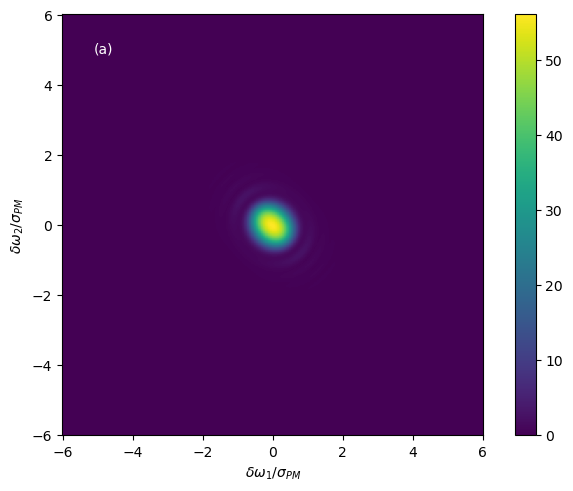

In [7]:
fig1, axs1 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)
c1=axs1.pcolor(omf/jnp.sqrt(jnp.pi),omf/jnp.sqrt(jnp.pi), jsi_integral1, rasterized=True)

axs1.set_box_aspect(1)
axs1.set_xlabel(r'$\delta\omega_{1}/\sigma_{PM}$')
axs1.set_ylabel(r'$\delta\omega_{2}/\sigma_{PM}$')

fig1.colorbar(c1)
fig1.text(0.26,0.9, '(a)',color='white')
fig1.set_edgecolor('none')
plt.gca().set_aspect('equal')

# plt.savefig("Figures_export/jsi_ideal.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Reduced density matrix and its eigenvalue decomposition

In [8]:
## JSA data
jsa_data=JSA_3D1/jnp.linalg.norm(JSA_3D1)
rho_aD1=jnp.einsum('ijk,ljk->il',jsa_data,jsa_data)

In [9]:
vals,vects=jnp.linalg.eigh(rho_aD1)
print(jnp.einsum("ijk,i,j,k",jsa_data,vects[:,-1],vects[:,-1],vects[:,-1]))

0.9222103684773605


## Local oscillator optimization - Gradient descent

In [ ]:
# Objective function
def objective_func(f):
    """
    Parameters
    ----------
    f:  Local oscillator spectrum. 1d array containing real numbers. 
    
    Returns
    -------
    Negative overlap between the jsa and the local oscillator distribution,
    as defined in the paper.
    """
    fnorm=f/jnp.linalg.norm(f)
    jsa_overlap=jnp.abs(jnp.einsum("ijk,i,j,k",jsa_data,fnorm,fnorm,fnorm))
    return -jsa_overlap # We define it negative, because we are using the minimize solver, but our goal is to actually maximize it

In [ ]:
def optimizer(initial_seed_c0):
    """
    Parameters
    ----------
    initial_seed_c0:  Initial seed-Local oscillator spectrum. 1d array containing real numbers. 
    
    Returns
    -------
    result.params: Optimized local oscillator spectrum.
    result.state.fun_val: Value of the negative overlap between the jsa and the local oscillator distribution,
                        as defined in the paper.
    """
    solver=jaxopt.ScipyMinimize(fun=objective_func, maxiter=5000, tol=1e-10)
    # Running the optimizer:
    result=solver.run(initial_seed_c0)
    ans=(result.params,result.state.fun_val)
    return ans

In [ ]:
#Seed: Let's try first with a gaussian

seed_gauss=jnp.exp(-(1/2)*(T01**2/tauf1**2)*((omf))**2) # Seed initialization
result_gauss_gd=optimizer(seed_gauss)  # Run optimizer
mode_gauss_optimgd=result_gauss_gd[0]/jnp.linalg.norm(result_gauss_gd[0]) # Local oscillator distribution obtained from the optimizer
overlap_gauss_optimgd=result_gauss_gd[1] # Value of the overlap with the jsa
print(overlap_gauss_optimgd)

-0.9223175416743731


In [ ]:
## Let's check with a uniform distribution seed
keygd=random.PRNGKey(74291)
seed_uniformgd=random.uniform(keygd,shape=(omf.shape),minval=0.0) # Seed initialization
result_uniform_gd=optimizer(seed_uniformgd) # Run optimizer
mode_uniform_optimgd=result_uniform_gd[0]/jnp.linalg.norm(result_uniform_gd[0]) # Local oscillator distribution obtained from the optimizer
overlap_uniform_optimgd=result_uniform_gd[1] # Value of the overlap with the jsa
print(overlap_uniform_optimgd)

-0.922317541674373


## Local oscillator optimization - Basin hopping

In [14]:
### The following function returns the function value and the gradient:
objective_func_value_grad = jit(jax.value_and_grad(objective_func, argnums=0))

In [ ]:
def optimizer_basinhop(ini_seed):
    """
    Parameters
    ----------
    ini_seed: Initial seed-Local oscillator spectrum. 1d array containing real numbers. 
    
    
    Returns
    -------
    Results of the basin hopping Scipy optimizer with 'L-BFGS-B' method for local
    optimization: (solution.x, solution.fun, solution.success*1.0) where
    solution.x is the local oscillator distribution that optimize the objective function,
    solution.fun is the negative JSA overlap value with an optimal local oscillator,
    solution.success*1.0 is 1.0 if the optimizer is successful and 0.0 otherwise
    """

    ### Options for the optimizer:
    minimizer_kwargs = {
        "method": "L-BFGS-B",  # Local optimizer method
        "jac": True,  # JAX gradient provides gradients automatically
        "options": {"maxiter": 1000, "ftol": 1e-9}
    }

    ### Optimizing using the basinhoping optimizer with the gradient and the initial
    #### seed passed to it (note that the objective function contains the normalization)
    solution = scipy.optimize.basinhopping(
        func=objective_func_value_grad,
        x0=ini_seed,
        niter=100,
        T=1.0,
        stepsize=0.5,
        minimizer_kwargs=minimizer_kwargs,
    )

    mode_unnormalized = solution.x
    mode_norm = jnp.linalg.norm(solution.x)

    optimal_mode = mode_unnormalized/mode_norm

    return (optimal_mode, solution.fun, solution.success * 1.0)
 

In [ ]:
#Seed: Let's try first with a gaussian
result_gauss_bh=optimizer_basinhop(seed_gauss) # Run optimizer -Basin hopping method
mode_gauss_optimbh=result_gauss_bh[0] # Local oscillator distribution obtained from the optimizer
overlap_gauss_optimbh=result_gauss_bh[1] # Value of the overlap with the jsa
print(overlap_gauss_optimbh)

-0.9223175401572827


In [ ]:
## Let's check with a uniform distribution seed
keybh=random.PRNGKey(74291)
seed_uniformbh=random.uniform(keybh,shape=(omf.shape),minval=0.0) # Seed initialization
result_uniform_bh=optimizer_basinhop(seed_uniformbh) # Run optimizer -Basin hopping method
mode_uniform_optimbh=result_uniform_bh[0] # Local oscillator distribution obtained from the optimizer
overlap_uniform_optimbh=result_uniform_bh[1] # Value of the overlap with the jsa
print(overlap_uniform_optimbh)

-0.9223175255811835


### Overlap and gradient

In [ ]:
# Overlap between the optimized local oscillator amplitudes and the dominant mode of the eigendecomposition of the reduced density matrix


overlap_eigen_gauss=jnp.dot(mode_gauss_optimgd,vects[:,-1])
overlap_eigen_unif=jnp.dot(mode_uniform_optimgd,vects[:,-1])
overlap_eigen_gaussbh=jnp.dot(mode_gauss_optimbh,vects[:,-1])
overlap_eigen_unifbh=jnp.dot(mode_uniform_optimbh,vects[:,-1])
print(overlap_eigen_gauss)
print(overlap_eigen_unif)
print(overlap_eigen_gaussbh)
print(overlap_eigen_unifbh)

0.9999606635419126
0.9999606635401749
0.9999607584367127
0.9999605957479025


In [19]:
func_value_grad=jax.value_and_grad(objective_func,argnums=0)
valeig,gradeig=func_value_grad(vects[:,-1])
valcoptggd,gradcoptggd=func_value_grad(mode_gauss_optimgd)
valcoptugd,gradcoptugd=func_value_grad(mode_uniform_optimgd)
valcoptgbh,gradcoptgbh=func_value_grad(mode_gauss_optimbh)
valcoptubh,gradcoptubh=func_value_grad(mode_uniform_optimbh)
print('Func gradient with Dominant mode of rho: '+str(jnp.linalg.norm(gradeig))) # Dominant mode of rho
print('Func gradient with Gauss seed-Gradient descent method: '+str(jnp.linalg.norm(gradcoptggd)))  #Gauss seed-Gradient descent
print('Func gradient with Uniform seed - Gradient descent method: '+str(jnp.linalg.norm(gradcoptugd))) # Uniform seed - Gradient descent
print('Func gradient with Gauss seed-Basin hopping method: '+str(jnp.linalg.norm(gradcoptgbh))) # Gauss seed-Basin hopping
print('Func gradient with  Uniform seed - Basin hopping method: '+str(jnp.linalg.norm(gradcoptubh))) # Uniform seed - Basin hopping

Func gradient with Dominant mode of rho: 0.02452414501718437
Func gradient with Gauss seed-Gradient descent method: 5.579228027181415e-09
Func gradient with Uniform seed - Gradient descent method: 4.4545123835125585e-08
Func gradient with Gauss seed-Basin hopping method: 0.00010032025021499768
Func gradient with  Uniform seed - Basin hopping method: 0.0002997234567669945


### Plot

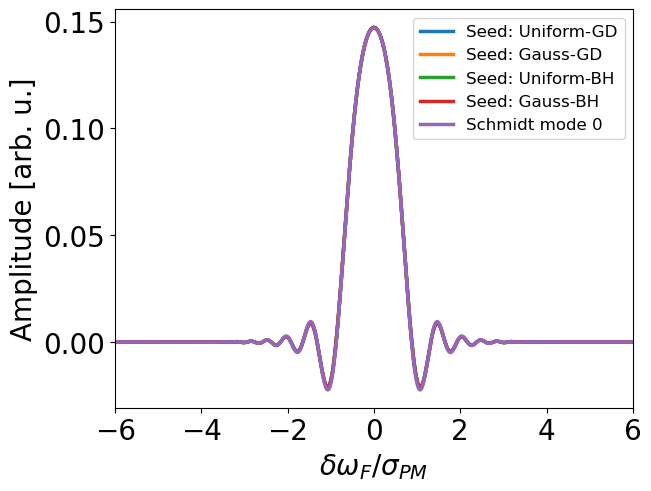

In [21]:
font={'size':20}
plt.rc('font',**font)

figm, axsm = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

plt.plot(omf/jnp.sqrt(jnp.pi),mode_uniform_optimgd,label='Seed: Uniform-GD',linewidth=2.5)
plt.plot(omf/jnp.sqrt(jnp.pi),mode_gauss_optimgd,label='Seed: Gauss-GD',linewidth=2.5)
plt.plot(omf/jnp.sqrt(jnp.pi),mode_uniform_optimbh,label='Seed: Uniform-BH',linewidth=2.5)
plt.plot(omf/jnp.sqrt(jnp.pi),mode_gauss_optimbh,label='Seed: Gauss-BH',linewidth=2.5)
plt.plot(omf/jnp.sqrt(jnp.pi),vects[:,-1],label='Schmidt mode 0',linewidth=2.5)
plt.xlabel(r'$\delta\omega_{F}/\sigma_{PM}$')
plt.ylabel("Amplitude [arb. u.]") 



plt.xlim(-6,6)
plt.legend(fontsize=12)  

plt.savefig("Figures_export/Gradient_descent_rco849nm.pdf", format="pdf", bbox_inches="tight")


plt.show()